In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
## need biopython to run: https://anaconda.org/anaconda/biopython
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
## need OligoArrayAux to run: http://www.unafold.org/Dinamelt/software/OligoArrayAux.php
import oligo_melting as OligoMelt

In [2]:
sns.set()

## Featurization
### Functions
can definitely be improved upon

In [3]:
def letter_at_position(string, letter, position):
    ## takes in a string, letter (both as strings), and position as an integer
    ## returns boolean whether the given letter is at the given position in the string
    return string[position:position+1].__eq__(letter)

def tuple_at_position(string, letters, position):
    ## takes in a string, 2 letters (as a single string) and position as an integer
    ## returns boolean whether the given letters are at the given position in the string
    return string[position:position+2].__eq__(letters)

def triple_at_position(string, letters, position):
    ## takes in a string, 3 letters (as a single string) and position as an integer
    ## returns boolean whether the given letters are at the given position in the string
    return string[position:position+3].__eq__(letters)

def find_PAM(sequence, PAM):
    ## takes in sequence and PAM as strings representing genetic target sequence and the promotospacer-adjacent motif
    ## of the gene editing complex
    ## returns the position as an int or -1 if not found
    match = re.search(PAM, sequence)
    return match.start()

def gc_count(string):
    ## takes in a string
    ## returns an integer representing the number of G or C letters in that string
    count = 0
    for letter in string:
        if letter.__eq__('G') | letter.__eq__('C'):
            count=count+1
    return count

## Doench et al 2014 DataFrame

In [4]:
df_doench=pd.ExcelFile("Doench 2014 Supplemental Tables.xlsx")
print(df_doench.sheet_names)

['Table Legends', 'Supp Table 1', 'Supp Table 2', 'Supp Table 3', 'Supp Table 4', 'Supp Table 5', 'Supp Table 6', 'Supp Table 7', 'Supp Table 8', 'Supp Table 9', 'Supp Table 10']


In [5]:
df_table_features=pd.read_excel("Doench 2014 Supplemental Tables.xlsx", sheet_name="Supp Table 8")
df_table_features.head()

,Feature,prob,oddsratio,quantity,odds,stdev,delta_devs,p-value
0,A01,0.187970,0.996638,399,0.231481,0.019579,-0.026282,0.979032
1,A02,0.207182,1.125124,362,0.261324,0.020556,0.909617,0.363025
2,A03,0.164835,0.849765,364,0.197368,0.020499,-1.153676,0.248633
3,A04,0.209877,1.143642,405,0.265625,0.019434,1.100761,0.271001
4,A05,0.172324,0.896408,383,0.208202,0.019984,-0.808677,0.418701


In [6]:
df_doench=pd.read_excel("Doench 2014 Supplemental Tables.xlsx", sheet_name="Supp Table 10")
df_doench.head()

,Spacer Sequence,Expanded Sequence,Spacer_ID,Gene Symbol,Essential Gene Set,Expression Value (CCLE),Early Time Point,DMSO Day 14 Rep 1,DMSO Day 14 Rep 2,ETP - DMSO,Gene Avg,Normalized sgRNA Activity,sgRNA Score
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,s_40338,PARS2,aminoacyl,7.013512,3.623884,3.727199,2.739853,0.390358,1.173702,-0.783345,0.325738
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,s_40337,PARS2,aminoacyl,7.013512,3.432073,0.942266,2.950215,1.485832,1.173702,0.312129,0.162559
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,s_40336,PARS2,aminoacyl,7.013512,4.679738,3.576145,2.493495,1.644918,1.173702,0.471215,0.035653
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,s_32891,MARS2,aminoacyl,7.065261,2.050553,1.291687,1.034652,0.887383,1.086888,-0.199505,0.311042
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,s_32889,MARS2,aminoacyl,7.065261,5.252744,4.041662,4.907459,0.778184,1.086888,-0.308705,0.199951


## Fusi et al 2015

In [7]:
df_fusi=pd.read_csv("Fusi_Data.csv")
df_fusi.head()

,Unnamed: 0,30mer,Target gene,Percent Peptide,Amino Acid Cut position,score_drug_gene_rank,score_drug_gene_threshold,drug,predictions
0,0,CAGAAAAAAAAACACTGCAACAAGAGGGTA,CD5,72.87,360.0,0.083682,0,nodrug,0.544412
1,1,TTTTAAAAAACCTACCGTAAACTCGGGTCA,NF1,65.80,1868.0,0.868207,1,PLX_2uM,0.617512
2,2,TCAGAAAAAGCAGCGTCAGTGGATTGGCCC,CD5,84.21,416.0,0.184100,0,nodrug,0.476232
3,3,AATAAAAAATAGGATTCCCAGCTTTGGAAG,NF1,56.39,1601.0,0.432065,0,PLX_2uM,0.459882
4,4,GATGAAAAATATGTAAACAGCATTTGGGAC,CUL3,4.30,33.0,0.149351,0,PLX_2uM,0.290841


In [26]:
df_fusi.shape

(5310, 9)

Need to find more data

### Isolating necessary data into one dataframe
- combine only necessary columns into one succinct dataframe
    - include anything that could be useful to models
- plot some graphs to visualize data

In [8]:
## to do
df_features=df_doench[["Spacer Sequence","Expanded Sequence","sgRNA Score"]]
df_features["sgRNA Rank"] = df_features["sgRNA Score"].rank(method='max')
n = df_features["sgRNA Rank"].size
# D=(r − 3/8) / (n + 1/4)
df_features["sgRNA Normalized"] = (df_features["sgRNA Rank"] - (3/8)) / (n + 1/4)
df_features.head()

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Spacer Sequence,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,1010.0,0.789849
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,707.0,0.552807
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,191.0,0.149130
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,982.0,0.767944
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,803.0,0.627909


#### Normalization Verification

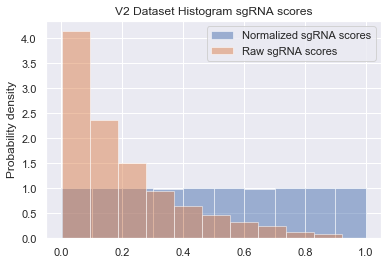

In [9]:
plt.hist(df_features["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df_features["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("V2 Dataset Histogram sgRNA scores")
plt.legend()

### V1 Featurization
can definitely be improved upon

In [10]:
df_V1 = df_features.copy(deep=True) ## creates a hard copy of supplementary table 7 data to work with
df_V1['Sequence'] = df_V1['Spacer Sequence'].astype('string') ## sets data of sequence to String for parsing
df_V1['Expanded Sequence'] = df_V1['Expanded Sequence'].astype('string') ## sets data of sequence to String for parsing
df_V1['Expanded Sequence']

0       GGCCGTAATGGCTTCCTCGTGAGTTGGTCC
1       AGAAGCTCGTGCGAGTGATAGACCAGGAGA
2       ATGGCACGGACGGTATATGGCAGGAGGTGG
3       TGGCTACTTCTGCGAGACACGGACAGGTCG
4       ACTTCGGCCCACGCTACTACAGTTCGGGCT
                     ...              
1273    AAAAGATACTACCTAGAGGATTGAAGGGAA
1274    ACAGAAGAAGCCTTAAGACACCCGTGGCTT
1275    TTCCCTGTTGGAGAAATCACCAACCGGCTC
1276    AAAATGAATCCACAGCTCTACCCCAGGTTC
1277    AGGCAGCCCTCCCTTGCCTTCCTCTGGACC
Name: Expanded Sequence, Length: 1278, dtype: string

In [11]:
V1_bool_parameters=["GC<10","GC>10"]

for k in range(30):
    ## creates columns for each nucleotide at each position in sequence
    for x in ['A',"G","C","T"]:
        df_V1[x + str(k+1)] = letter_at_position(df_V1['Sequence'],x,k)
        V1_bool_parameters.append(x + str(k+1))
        if k < 29:
            for y in ["A","G","C","T"]:
                df_V1[x + y + str(k+1)] = tuple_at_position(df_V1['Sequence'],x+y,k)
                V1_bool_parameters.append(x + y + str(k+1))
        else:
            for y in ["A","G","C","T"]:
                df_V1[x + y + "?"] =  False # not technically correct but will work as placeholder
                df_V1[x + y + "_PAM"] = False # this as well
                V1_bool_parameters.append(x + y + "?")
                V1_bool_parameters.append(x + y + "_PAM")
        df_V1[x + "?"] = False # same with this
        V1_bool_parameters.append(x + "?")
        
df_V1['GC Count'] = -1 ## creates column for GC count
df_V1["PAM position (expanded sequence)"] = -1

df_V1['Melting Temp Wallace'] = 0
df_V1['Melting Temp GC'] = 0
df_V1['Melting Temp NN1'] = 0
df_V1['Melting Temp NN2'] = 0
df_V1['Melting Temp NN3'] = 0
df_V1['Melting Temp NN4'] = 0

df_V1["GC<10"] = False
df_V1["GC>10"] = False

In [12]:
for a in range(df_V1['Sequence'].size):
    ## loops through each sequence and computes the necessary one-hot nucleotide encoding features
    for k in range(30):
        for x in ['A',"G","C","T"]:
            df_V1[x + str(k+1)][a] = letter_at_position(df_V1['Sequence'][a],x,k)
            if k < 29:
                for y in ["A","G","C","T"]:
                    df_V1[x + y + str(k+1)][a] = tuple_at_position(df_V1['Sequence'][a],x+y,k)
                    if (not df_V1[x + y + "?"][a]):
                        df_V1[x + y + "?"][a] = df_V1[x + y + str(k+1)][a]
            
            if (not df_V1[x + "?"][a]):
                df_V1[x + "?"][a] = df_V1[x + str(k+1)][a]
                        
    ## generates the GC count data for each column
    df_V1['GC Count'][a] = gc_count(df_V1['Sequence'][a])
    ## calculates the PAM position for each sequence
    df_V1["PAM position (expanded sequence)"][a] = find_PAM(df_V1["Expanded Sequence"][a],"GG")

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [13]:
for a in range(df_V1['Expanded Sequence'].size):
    df_V1["PAM position (expanded sequence)"][a] = find_PAM(df_V1["Expanded Sequence"][a],"GG")
    for x in ['A',"G","C","T"]:
        for y in ['A',"G","C","T"]:
            df_V1[x + y + "_PAM"] = tuple_at_position(df_V1["Expanded Sequence"][a],
                                                      x+y,
                                                      df_V1["PAM position (expanded sequence)"][a]-3)
    seq = Seq(df_V1["Expanded Sequence"][a])
    df_V1["Melting Temp Wallace"][a] = mt.Tm_Wallace(seq)
    df_V1["Melting Temp GC"][a] = mt.Tm_GC(seq)
    df_V1["Melting Temp NN1"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN1)
    df_V1["Melting Temp NN2"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN2)
    df_V1["Melting Temp NN3"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN3)
    df_V1["Melting Temp NN4"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN4)
    
    df_V1["GC<10"][a] = df_V1["GC Count"][a] < 10
    df_V1["GC>10"][a] = df_V1["GC Count"][a] > 10

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while w

In [14]:
for v1 in V1_bool_parameters:
    df_V1[v1]=df_V1[v1].astype(int)

In [15]:
df_V1.to_csv('Doench2014_V1_Featurized.csv')
df_V1.head()

,Spacer Sequence,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,Sequence,A1,AA1,AG1,AC1,...,GC Count,PAM position (expanded sequence),Melting Temp Wallace,Melting Temp GC,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,1010.0,0.789849,GTAATGGCTTCCTCGTGAGT,0,0,0,0,...,10,0,96,64,78,70,65,68,0,0
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,707.0,0.552807,GCTCGTGCGAGTGATAGACC,0,0,0,0,...,12,25,92,61,72,69,63,64,0,1
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,191.0,0.149130,CACGGACGGTATATGGCAGG,0,0,0,0,...,12,2,96,64,79,70,66,70,0,1
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,982.0,0.767944,TACTTCTGCGAGACACGGAC,0,0,0,0,...,11,1,96,64,77,71,66,67,0,1
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,803.0,0.627909,CGGCCCACGCTACTACAGTT,0,0,0,0,...,12,5,96,64,78,72,67,70,0,1


### V2 Featurization
can definitely be improved upon

In [16]:
df_V2 = df_V1.copy(deep=True)
V2_bool_parameters=V1_bool_parameters

In [17]:
df_V2["AAAAA"] = "AAAAA" in df_V2["Expanded Sequence"] ## initializes each column to false
df_V2["GGGGG"] = "GGGGG" in df_V2["Expanded Sequence"]
df_V2["CCCCC"] = "CCCCC" in df_V2["Expanded Sequence"]
df_V2["TTTTT"] = "TTTTT" in df_V2["Expanded Sequence"]
V2_bool_parameters.append(["AAAAA","GGGGG","CCCCC","TTTTT"])
df_V2.head()

,Spacer Sequence,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,Sequence,A1,AA1,AG1,AC1,...,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10,AAAAA,GGGGG,CCCCC,TTTTT
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,1010.0,0.789849,GTAATGGCTTCCTCGTGAGT,0,0,0,0,...,78,70,65,68,0,0,False,False,False,False
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,707.0,0.552807,GCTCGTGCGAGTGATAGACC,0,0,0,0,...,72,69,63,64,0,1,False,False,False,False
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,191.0,0.149130,CACGGACGGTATATGGCAGG,0,0,0,0,...,79,70,66,70,0,1,False,False,False,False
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,982.0,0.767944,TACTTCTGCGAGACACGGAC,0,0,0,0,...,77,71,66,67,0,1,False,False,False,False
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,803.0,0.627909,CGGCCCACGCTACTACAGTT,0,0,0,0,...,78,72,67,70,0,1,False,False,False,False


In [18]:
for k in range(29):
    for x in ['A',"G","C","T"]:
        for y in ['A',"G","C","T"]:
            for z in ["A","G","C","T"]:
                
                if k < 28:
                    df_V2[x + y + z + str(k+1)] = False
                    V2_bool_parameters.append(x + y + z + str(k+1))
                else:
                    df_V2[x+y+z] = False
                    V2_bool_parameters.append(x+y+z)
df_V2["Delta G"] = 0
df_V2.head()

,Spacer Sequence,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,Sequence,A1,AA1,AG1,AC1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,1010.0,0.789849,GTAATGGCTTCCTCGTGAGT,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,707.0,0.552807,GCTCGTGCGAGTGATAGACC,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,191.0,0.149130,CACGGACGGTATATGGCAGG,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,982.0,0.767944,TACTTCTGCGAGACACGGAC,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,803.0,0.627909,CGGCCCACGCTACTACAGTT,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0


In [19]:
for a in range(df_V2['Expanded Sequence'].size):
    df_V2["AAAAA"][a] = "AAAAA" in df_V2["Expanded Sequence"][a]
    df_V2["GGGGG"][a] = "GGGGG" in df_V2["Expanded Sequence"][a]
    df_V2["CCCCC"][a] = "CCCCC" in df_V2["Expanded Sequence"][a]
    df_V2["TTTTT"][a] = "TTTTT" in df_V2["Expanded Sequence"][a]
    
    for k in range(29):
        for x in ['A',"G","C","T"]:
            for y in ['A',"G","C","T"]:
                for z in ["A","G","C","T"]:

                    if k < 28:
                        df_V2[x + y + z + str(k+1)][a] = triple_at_position(df_V2["Expanded Sequence"][a], x+y+z, k)
                        if (not df_V2[x+y+z][a]):
                            df_V2[x+y+z][a] = df_V2[x + y + z + str(k+1)][a]

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [20]:
for a in range(df_V2['Sequence'].size):
    ## note that this uses the 20-n.t. guide RNA sequence
    ## all previously calculated features use the 30-oligo target sequence
    
    # # Calculate melting temperature for 25uM oligos
    # (name, g, h, s, tm, seq)
    df_V2["Delta G"][a] = OligoMelt.Duplex.calc_tm(df_V2["Sequence"][a])[1]

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
for v2 in V2_bool_parameters:
    df_V2[v2]=df_V2[v2].astype(int)

In [22]:
df_V2.to_csv('Doench2014_V2_Featurized.csv')
df_V2.head()

,Spacer Sequence,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,Sequence,A1,AA1,AG1,AC1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GTAATGGCTTCCTCGTGAGT,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,1010.0,0.789849,GTAATGGCTTCCTCGTGAGT,0,0,0,0,...,0,0,1,1,0,0,1,1,0,-24
1,GCTCGTGCGAGTGATAGACC,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,707.0,0.552807,GCTCGTGCGAGTGATAGACC,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-26
2,CACGGACGGTATATGGCAGG,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,191.0,0.149130,CACGGACGGTATATGGCAGG,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-26
3,TACTTCTGCGAGACACGGAC,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,982.0,0.767944,TACTTCTGCGAGACACGGAC,0,0,0,0,...,0,0,1,0,1,0,0,1,0,-25
4,CGGCCCACGCTACTACAGTT,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,803.0,0.627909,CGGCCCACGCTACTACAGTT,0,0,0,0,...,0,0,1,0,0,0,0,1,0,-27


In [25]:
df_V2.shape

(1278, 2497)

### V3

In [23]:
# to do